# Baseline Naive Bayes model

A Naive Bayes classifier determines the probability that an input text belongs to one of a set of classes, eg. predicting if a review is positive or negative.

It is ‘Naive’ because it assumes the words in the text are independent (even though in reality, in natural human language, the order of words convey contextual information).  Despite these assumptions, Naive Bayes has a high degree of accuracy when predicting classes with only a small training set.

- https://medium.com/the-data-science-publication/how-to-predict-natural-language-sentiment-using-naive-bayes-classifier-6ab6eb28fd6d
- Baines, O., Naive Bayes: Machine Learning and Text Classification Application of Bayes’ Theorem. https://journals.le.ac.uk/ojs1/index.php/lumj/article/download/3484/3110

In [2]:
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from NLPmoviereviews.data import load_data_sent
from NLPmoviereviews.utilities import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Load/inspect data

In [3]:
# load data
X_train, y_train, X_test, y_test = load_data_sent(percentage_of_sentences=10)

2022-08-09 13:04:58.136264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 13:04:58.183592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


In [4]:
# create dataframe from data
d = {'text': X_train, 'sentiment': y_train}
df = pd.DataFrame(d)

df.head()

,text,sentiment
0,this was an absolutely terrible movie don't be...,0
1,i have been known to fall asleep during films ...,0
2,mann photographs the alberta rocky mountains i...,0
3,this is the kind of film for a snowy sunday af...,1
4,as others have mentioned all the women that go...,1


In [5]:
# check shape
df.shape

(2500, 2)

In [6]:
# check class balance (it's pretty balanced)
df.sentiment.value_counts()

0    1265
1    1235
Name: sentiment, dtype: int64

In [7]:
df.text[0]

"this was an absolutely terrible movie don't be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher walken's good name i could barely sit through it"

## Preprocess

removing custom stop words improves score (negligible, + ~0.002%)

In [8]:
# remove custom stop-words (improves accuracy)
def rm_custom_stops(sentence):
    '''
    Custom stop word remover
    Parameters:
        sentence (str): a string of words
    Returns:
        list_of_words (list): cleaned sentence as a list of words
    '''
    words = sentence.split()
    stop_words = {'br', 'movie', 'film'}
    cleaned_words = [w for w in words if not w in stop_words]
    return ' '.join(cleaned_words)

In [9]:
# clean text data
df['text'] = df.text.apply(preprocessing)
df['text'] = df.text.apply(rm_custom_stops)
df.head()

,text,sentiment
0,absolutely terrible dont lure christopher walk...,0
1,know fall asleep usually due combination thing...,0
2,mann photograph alberta rocky mountain superb ...,0
3,kind snowy sunday afternoon rest world go ahea...,1
4,others mention woman go nude mostly absolutely...,1


Note: Changing n-grams doesn't seem to help. N-grams are the number of words around the target word to consider - increasing n-grams can help the machine understand a word in its context to better analyze the meaning of the word.

Example:
- vectorizer = CountVectorizer(ngram_range = (2,2)) # produces lower accuracy (78%)
- vectorizer = CountVectorizer(ngram_range = (5,5)) # produces even lower accuracy (50%)


In [22]:
# vectorize text (convert collection of texts to a matrix of token counts)
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(df.text)

## Process test data

In [23]:
# process test data
d_test = {'text': X_test}
df_test = pd.DataFrame(d_test)      # create dataframe
df_test['text'] = df_test.text.apply(preprocessing)     # preprocess
df_test['text'] = df_test.text.apply(rm_custom_stops)
X_test_count = vectorizer.transform(df_test.text)     # vectorize

## Cross-validate model

In [24]:
# initialize & cross validate a basic model
naivebayes = MultinomialNB()
cv_nb = cross_validate(naivebayes,
                       X_train_count,
                       y_train,
                       scoring = "accuracy")

In [25]:
# evaluate accuracy
cv_nb['test_score'].mean()

0.8276

## Fit cross-validated model

In [26]:
# fit model
naivebayes.fit(X_train_count, y_train)

MultinomialNB()

## Evaluate model

In [27]:
# get accuracy score
naivebayes.score(X_test_count, y_test)

0.808

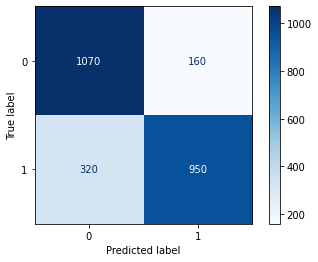

In [28]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(naivebayes,
                             X_test_count, y_test,
                             cmap="Blues");

# 160 false positives, 323 false negatives

In [29]:
# print classification report
Y_predict = naivebayes.fit(X_train_count, y_train).predict(X_test_count)
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1230
           1       0.86      0.75      0.80      1270

    accuracy                           0.81      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.81      0.81      0.81      2500



# Alternative methods (trying to improve score, nothing worked)

### Use TF-IDF vectorizer (term frequency inverse document frequency)

TF-IDF looks at word frequency across all documents (reviews), and can help identify key words that are used by all reviews. This approach may help eliminate frequent, but therefore less meaningful, corpus-specific words.

In [30]:
vectorizer = TfidfVectorizer(max_df=0.3) # ignore words with a frequency higher than this %
X_train_vec = vectorizer.fit_transform(df.text)
X_test_vec = vectorizer.transform(df_test.text)
model = MultinomialNB()
model.fit(X_train_vec, y_train)
model.score(X_test_vec, y_test)

0.8024

### Use ComplementNB model

helps with unbalanced classes

In [31]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(df.text)
X_test_vec = vectorizer.transform(df_test.text)
model = ComplementNB()
model.fit(X_train_vec, y_train)
model.score(X_test_vec, y_test)

0.808

### Clean HTML tags

clean data approach

In [32]:
import re

# function to remove html tags from text
def cleanHtml(review):
    cleanreg = re.compile('<.*?>')
    cleantxt = re.sub(cleanreg, ' ', review)
    return cleantxt

# load data
X_train, y_train, X_test, y_test = load_data_sent(percentage_of_sentences=10)

# process train data
df = pd.DataFrame({'text': X_train})
df.text = df.text.apply(cleanHtml)
df['text'] = df.text.apply(preprocessing)
df['text'] = df.text.apply(rm_custom_stops)
# process test data
df_test = pd.DataFrame({'text': X_test})
df_test.text = df_test.text.apply(cleanHtml)
df_test['text'] = df_test.text.apply(preprocessing)
df_test['text'] = df_test.text.apply(rm_custom_stops)

# modelling
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(df.text)
X_test_vec = vectorizer.transform(df_test.text)
model = ComplementNB()
model.fit(X_train_vec, y_train)
model.score(X_test_vec, y_test)

0.808

# Extra EDA: Method to get frequency distribution of words

In [33]:
#create a new column with words and word counts
vectorizer = CountVectorizer()
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    if analyzer(s):
        d = {}
        w = vectorizer.fit_transform([s]).toarray()
        vc = vectorizer.vocabulary_
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

df['Word Counts'] = df.text.apply(wordcounts)
df.head()

,text,Word Counts
0,absolutely terrible dont lure christopher walk...,"{'absolutely': 1, 'act': 1, 'actor': 2, 'affai..."
1,know fall asleep usually due combination thing...,"{'accord': 1, 'admit': 1, 'anything': 1, 'asle..."
2,mann photograph alberta rocky mountain superb ...,"{'alberta': 1, 'always': 1, 'american': 1, 'ap..."
3,kind snowy sunday afternoon rest world go ahea...,"{'afternoon': 1, 'ahead': 1, 'along': 1, 'alwa..."
4,others mention woman go nude mostly absolutely...,"{'ably': 1, 'absolutely': 1, 'age': 1, 'around..."


In [34]:
import operator

first_review = df['Word Counts'].iloc[0]
sorted_by_value = sorted(first_review.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_by_value )

[('actor', 2), ('christopher', 2), ('could', 2), ('great', 2), ('like', 2), ('pathetic', 2), ('walken', 2), ('absolutely', 1), ('act', 1), ('affair', 1), ('alonso', 1), ('appear', 1), ('barely', 1), ('case', 1), ('columbian', 1), ('conchita', 1), ('devoid', 1), ('disappoint', 1), ('dont', 1), ('early', 1), ('emotional', 1), ('even', 1), ('good', 1), ('history', 1), ('ironside', 1), ('love', 1), ('lure', 1), ('make', 1), ('maria', 1), ('mean', 1), ('michael', 1), ('must', 1), ('name', 1), ('ninety', 1), ('nothing', 1), ('phony', 1), ('piece', 1), ('plug', 1), ('propaganda', 1), ('pseudo', 1), ('real', 1), ('rebel', 1), ('redeem', 1), ('revolution', 1), ('ridiculous', 1), ('role', 1), ('ruin', 1), ('scene', 1), ('simply', 1), ('sit', 1), ('storyline', 1), ('terrible', 1), ('walkens', 1), ('worst', 1)]
